In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from requests import get
from urllib.parse import urlparse

import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

In [2]:
def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")
        
        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')
    
    else:
        print(f"Found {dfn} locally!")
    
    return dfn

In [3]:
url='https://bit.ly/3owocdI'
df = pd.read_csv(url) 
df['price'] = df.price.str.replace('$','').astype('float')

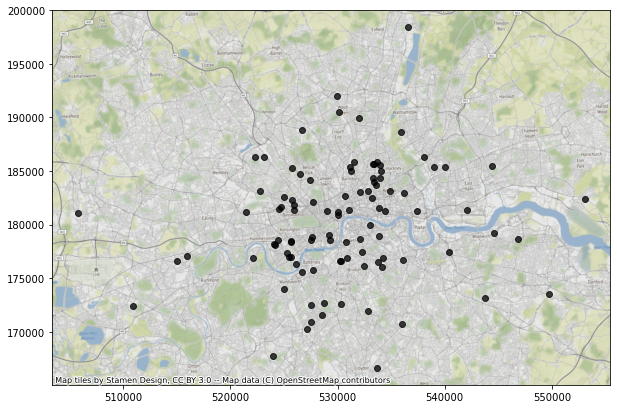

In [4]:
gdf = gpd.GeoDataFrame(df, 
            geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('EPSG:27700')

f, ax = plt.subplots(figsize=(10,8))
# Plot points
gdf.plot(alpha=0.75, color='black', ax=ax);
# Add background map with target CRS so basemap
# can be reprojected (warped)
ctx.add_basemap(ax, crs=gdf.crs)
plt.savefig(os.path.join('..','..','i2p','lectures','img','Basemap.png'), dpi=150)

[ 35.   55.  100.8 170.  798. ]
[21 20 19 21 19]


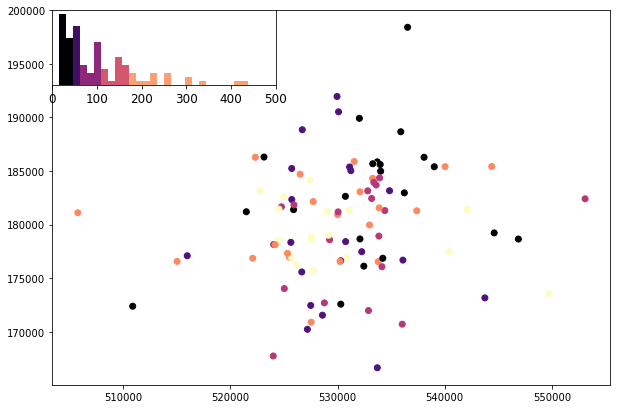

In [78]:
import pysal as ps
# https://github.com/pysal/mapclassify
import mapclassify as mc
# https://jiffyclub.github.io/palettable/
import palettable.matplotlib as palmpl
from legendgram import legendgram

f,ax = plt.subplots(figsize=(10,8))
gdf.plot(column='price', scheme='Quantiles', cmap='magma', k=5, ax=ax)
q = mc.Quantiles(gdf.price.values, k=5)

print(q.bins)
print(q.counts)

# https://github.com/pysal/legendgram/blob/master/legendgram/legendgram.py
legendgram(f, ax, 
               gdf.price, q.bins, pal=palmpl.Magma_5,
               legend_size=(.4,.2), # legend size in fractions of the axis
               loc = 'upper left', # matplotlib-style legend locations
               clip = (0,500), # clip the displayed range of the histogram
               frameon=True
           )

plt.savefig(os.path.join('..','..','i2p','lectures','img','Legendgram.png'), dpi=150)

In [82]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/'
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

Found data/geo/Boroughs.gpkg locally!


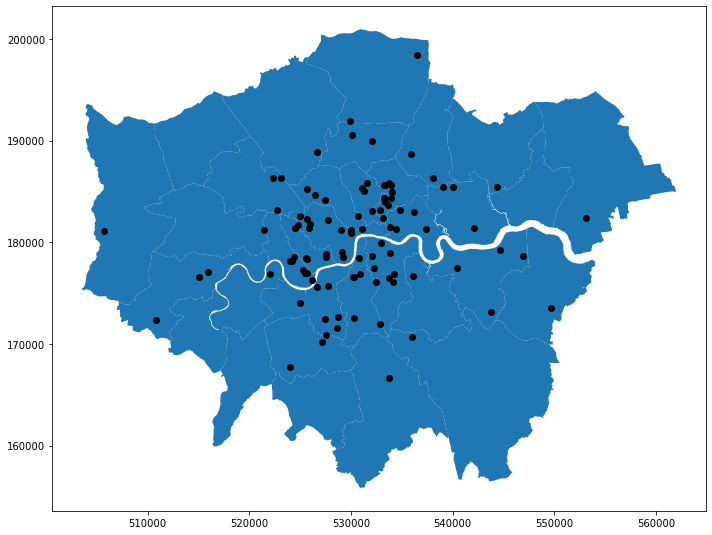

In [83]:
f, ax = plt.subplots(1,1,figsize=(10,8))
boros.plot(ax=ax)
gdf.plot(ax=ax, color='black')
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Boroughs.png'), dpi=150)

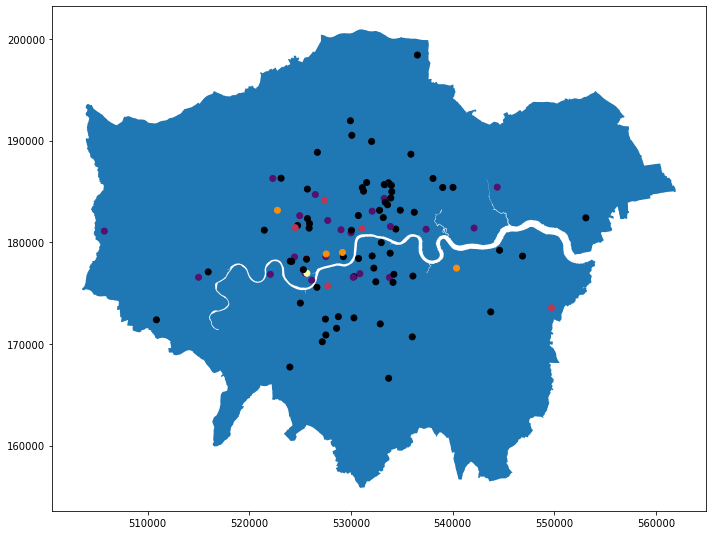

In [140]:
boros['region'] = 'London'
ldn = boros.dissolve(by='region')
f, ax = plt.subplots(1,1,figsize=(10,8))
ldn.plot(ax=ax)
gdf.plot(ax=ax, column='price', scheme='HeadTailBreaks', cmap='inferno')
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','London.png'), dpi=150)

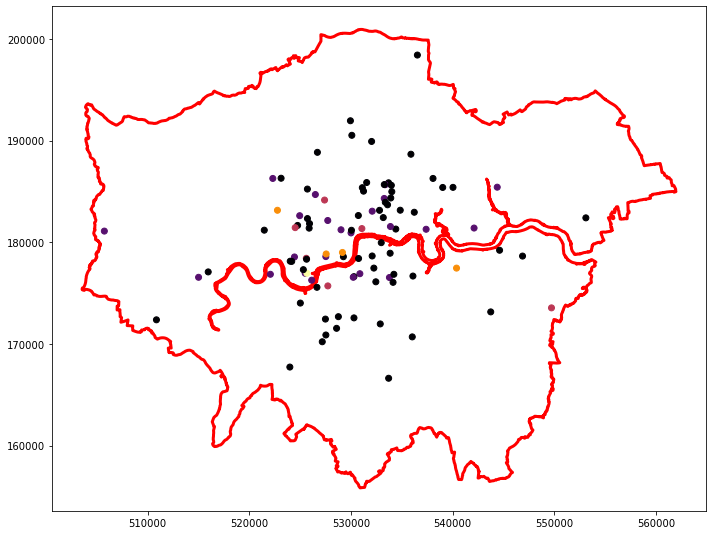

In [86]:
f, ax = plt.subplots(1,1,figsize=(10,8))
ldn.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3)
gdf.plot(ax=ax, column='price', scheme='HeadTailBreaks', cmap='inferno')
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','London_Airbnb.png'), dpi=150)

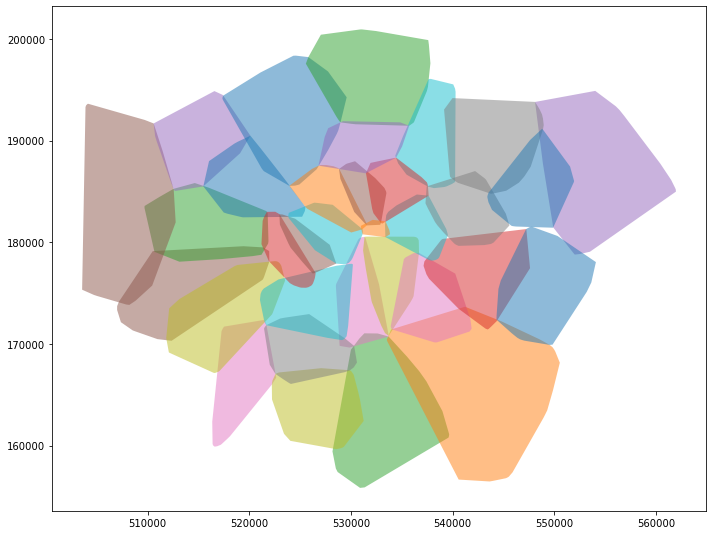

In [38]:
f, ax = plt.subplots(1,1,figsize=(10,8))
boros['hulls'] = boros.geometry.convex_hull
boros = boros.set_geometry('hulls')
boros.plot(ax=ax, column='NAME', categorical=True, alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Boroughs_Hull.png'), dpi=150)

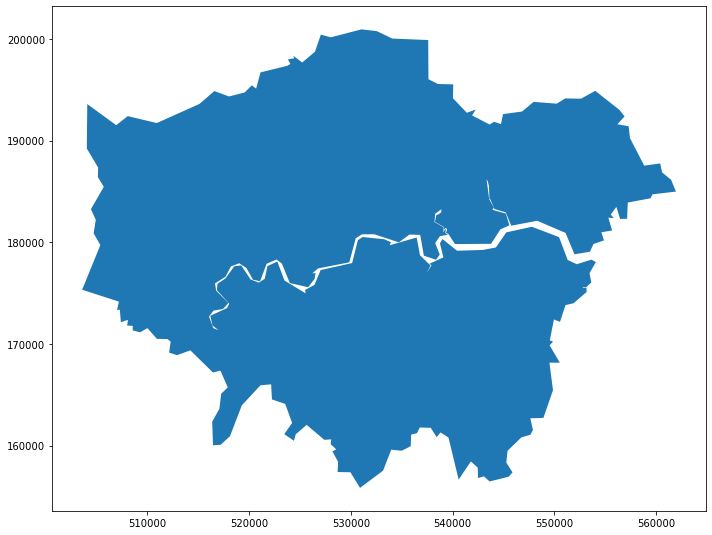

In [39]:
f, ax = plt.subplots(1,1,figsize=(10,8))
ldn.simplify(250).plot(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','London_Simplify.png'), dpi=150)

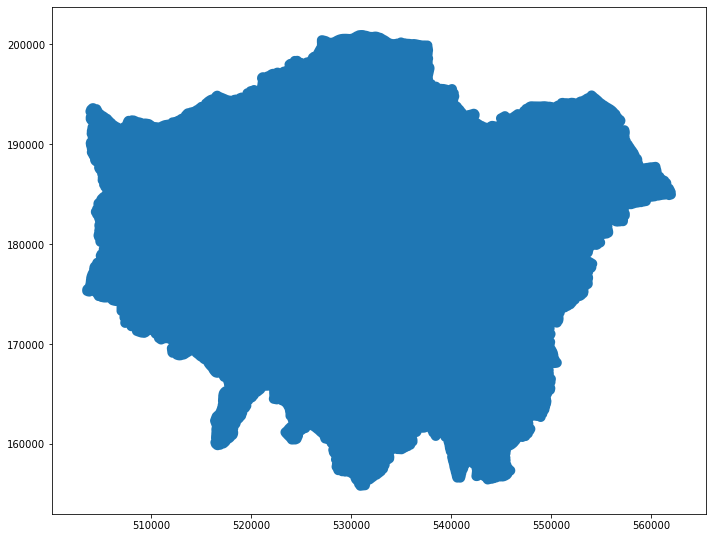

In [41]:
f, ax = plt.subplots(1,1,figsize=(10,8))
ldn.buffer(500).plot(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','London_Buffer.png'), dpi=150)

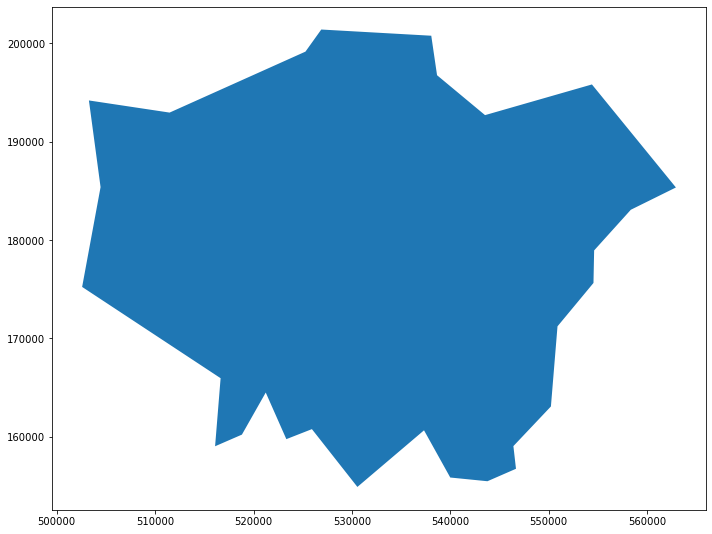

In [48]:
f, ax = plt.subplots(1,1,figsize=(10,8))
ldn.buffer(1000).simplify(1000).plot(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','London_Buffer_Simplify.png'), dpi=150)

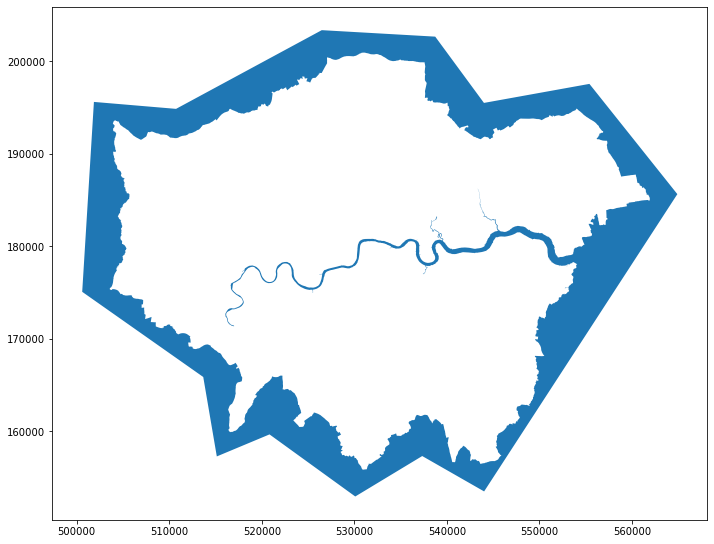

In [49]:
f, ax = plt.subplots(1,1,figsize=(10,8))
ldn.buffer(3000).simplify(2500).difference(ldn.geometry).plot(ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','London_Buffer_Simplify_Diff.png'), dpi=150)

In [9]:
w = weights.KNN.from_dataframe(gdf, k=3)
gdf['w_price'] = weights.lag_spatial(w, gdf.price)
gdf[['name','price','w_price']].sample(5, random_state=42)

,name,price,w_price
83,Southfields Home,85.0,263.0
53,"Flat in Islington, Central London",55.0,190.0
70,3bedroom Family Home minutes from Kensington Tube,221.0,470.0
45,"3 Bed, 20 min to Liverpool st, EAST LONDON",110.0,186.0
44,Avni Kensington Hotel,430.0,821.0


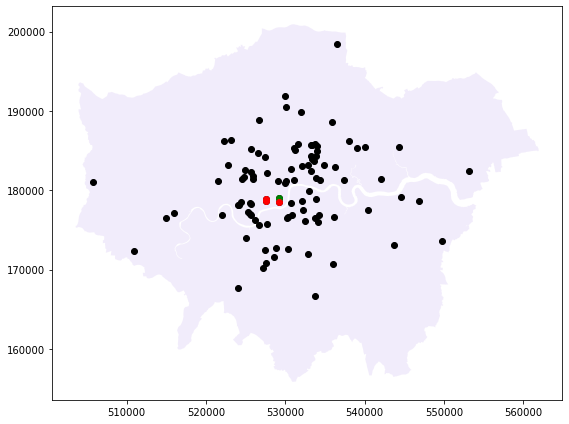

In [151]:
cid = 44 
ids = list(w[cid].keys())
f,ax=plt.subplots(figsize=(10,6))
ldn.plot(ax=ax, color='#cbb6f0', alpha=0.25)
gdf.plot(ax=ax, color='black')
gdf.loc[gdf.index==cid].plot(ax=ax, color='green')
# Notice this next one: https://pandas.pydata.org/pandas-docs/stable/reference/indexing.html
gdf.loc[gdf.index.isin(ids)].plot(ax=ax, color='red')

plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Airbnb_KNN_Example.png'), dpi=150)

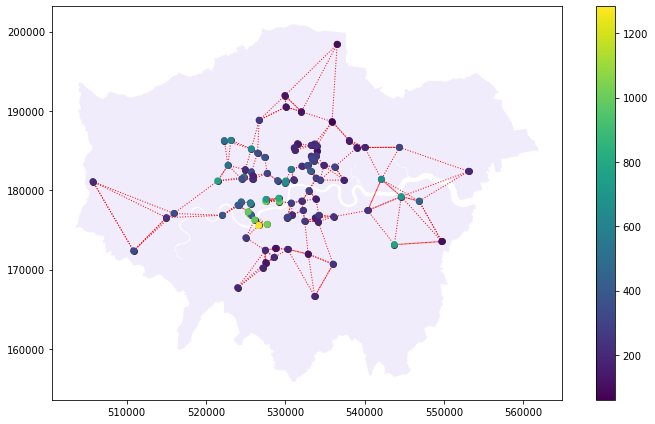

In [150]:
f,ax=plt.subplots(figsize=(10,6))
gdf.plot(ax=ax, column='w_price', cmap='viridis', legend=True, zorder=3)
ldn.plot(ax=ax, color='#cbb6f0', alpha=0.25, zorder=2)
w.plot(gdf, ax=ax, 
       edge_kws=dict(color='r', linestyle=':', linewidth=1))
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Airbnb_KNN.png'), dpi=150)

In [7]:
w2 = weights.DistanceBand.from_dataframe(gdf, threshold=2000, alpha=-0.25)
gdf['price_std'] = (gdf.price - gdf.price.mean()) / gdf.price.std()
gdf['w_price_std'] = weights.lag_spatial(w2, gdf.price_std)
gdf[['name','price_std','w_price_std']].sample(5, random_state=42)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 30 disconnected components.
 There are 23 islands with ids: 12, 19, 20, 22, 23, 26, 29, 31, 41, 43, 46, 51, 56, 61, 65, 66, 67, 78, 79, 83, 84, 89, 91.
  warnings.warn(message)


,name,price_std,w_price_std
83,Southfields Home,-0.270079,0.000000
53,"Flat in Islington, Central London",-0.512272,-0.580524
70,3bedroom Family Home minutes from Kensington Tube,0.827863,0.462385
45,"3 Bed, 20 min to Liverpool st, EAST LONDON",-0.068252,-0.819050
44,Avni Kensington Hotel,2.515141,3.246866


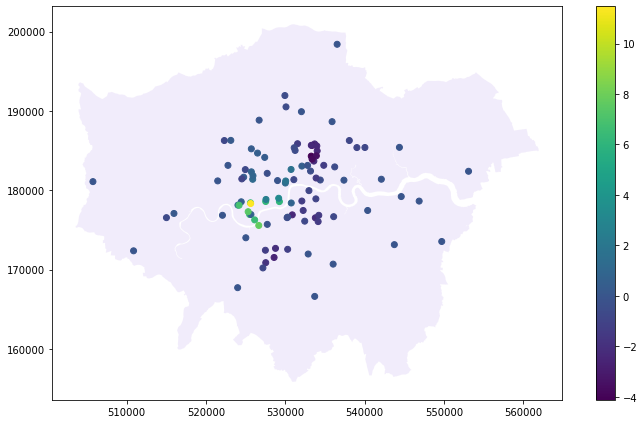

In [158]:
f,ax=plt.subplots(figsize=(10,6))
gdf.plot(ax=ax, column='w_price_std', cmap='viridis', legend=True, zorder=3)
ldn.plot(ax=ax, color='#cbb6f0', alpha=0.25, zorder=2)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Airbnb_DistanceBand.png'), dpi=150)

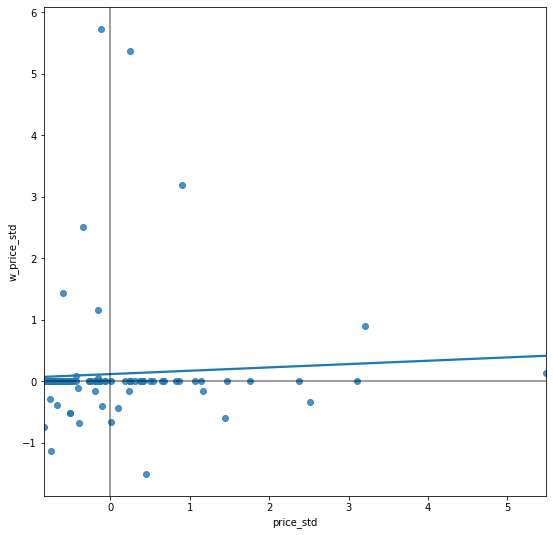

In [126]:
import seaborn as sns
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='price_std', y='w_price_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

0.1459079373166474
0.031


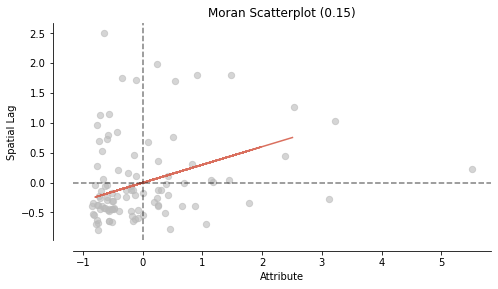

In [163]:
mi = esda.Moran(gdf['price'], w)
print(f"{mi.I:0.4f}")
print(f"{mi.p_sim:0.4f}")
f, ax = plt.subplots(figsize=(7,4))
moran_scatterplot(mi, ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Moran_Global.png'), dpi=150)

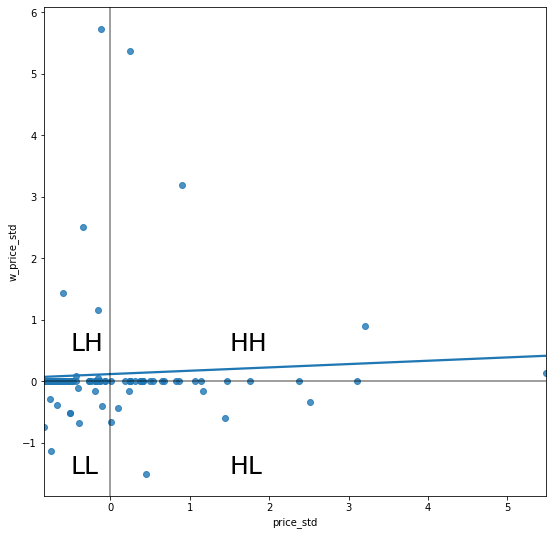

In [134]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='price_std', y='w_price_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.5, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-0.5, 0.5, "LH", fontsize=25)
plt.text(-0.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [14]:
lisa = esda.Moran_Local(gdf.price, w)
# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
gdf['quadrant'] = lisa.q
gdf[['name','price','significant','quadrant']].sample(5, random_state=42)

,name,price,significant,quadrant
83,Southfields Home,85.0,False,3
53,"Flat in Islington, Central London",55.0,False,3
70,3bedroom Family Home minutes from Kensington Tube,221.0,False,1
45,"3 Bed, 20 min to Liverpool st, EAST LONDON",110.0,False,3
44,Avni Kensington Hotel,430.0,False,1


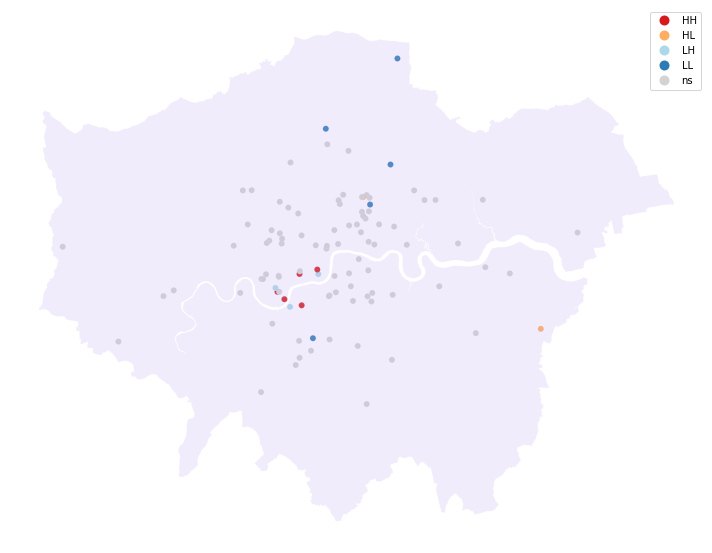

In [165]:
f, ax = plt.subplots(figsize=(10,8))
ldn.plot(ax=ax, color='#cbb6f0', alpha=0.25, zorder=2)
lisa_cluster(lisa, gdf, ax=ax)
plt.tight_layout()
plt.savefig(os.path.join('..','..','i2p','lectures','img','Moran_Local.png'), dpi=150)

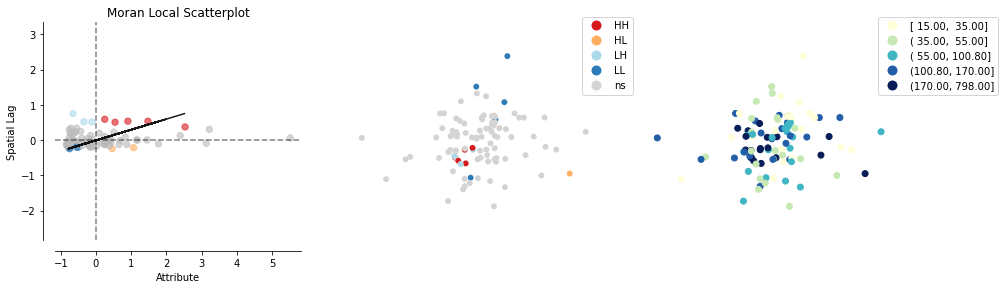

In [166]:
plot_local_autocorrelation(lisa, gdf, 'price')
plt.savefig(os.path.join('..','..','i2p','lectures','img','LISA.png'), dpi=150)